In [1]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import random
random.seed(2018)
print("Data:\n",os.listdir("../input"))

Data:
 ['test.csv', 'train_blurrness.csv', 'train.csv', 'training.csv', 'testing.csv', 'test_blurrness.csv']


In [2]:
# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
# Gradient Boosting
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold

/home/data/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords

In [5]:
# Viz
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

In [6]:
NFOLDS = 5
SEED = 2018
VALID = False
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

In [7]:
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [8]:
def cleanName(text):
    try:
        textProc = text.lower()
        # textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        #regex = re.compile(u'[^[:alpha:]]')
        #textProc = regex.sub(" ", textProc)
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(textProc.split())
        return textProc
    except: 
        return "name error"

In [9]:
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

In [10]:
print("\nData Load Stage")
training = pd.read_csv('../input/training.csv', index_col = "item_id", parse_dates = ["activation_date"])
traindex = training.index
testing = pd.read_csv('../input/testing.csv', index_col = "item_id", parse_dates = ["activation_date"])
testdex = testing.index


Data Load Stage


In [11]:
ntrain = training.shape[0]
ntest = testing.shape[0]

In [12]:
kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

In [13]:
y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

Train shape: 1503424 Rows, 18 Columns
Test shape: 508438 Rows, 18 Columns


In [14]:
print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Combine Train and Test

All Data shape: 2011862 Rows, 18 Columns


In [15]:
print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)
df["price"].fillna(df.price.mean(),inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

Feature Engineering


In [16]:
print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
#df["Weekd of Year"] = df['activation_date'].dt.week
#df["Day of Month"] = df['activation_date'].dt.day


Create Time Variables


In [17]:
# Create Validation Index and Remove Dead Variables
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
df.drop(["activation_date","image"],axis=1,inplace=True)

In [18]:
print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]
print("Encoding :",categorical)


Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1', 'param_1', 'param_2', 'param_3']


In [19]:
# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna('Unknown')
    df[col] = lbl.fit_transform(df[col].astype(str))
    
print("\nText Features")


Text Features


In [21]:
# Feature Engineering 

# Meta Text Features
textfeats = ["description", "title"]
df['desc_punc'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

In [22]:
for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words
    df[cols + '_num_letters'] = df[cols].apply(lambda comment: len(comment)) # Count number of Letters
    df[cols + '_num_alphabets'] = df[cols].apply(lambda comment: (comment.count(r'[a-zA-Z]'))) # Count number of Alphabets
    df[cols + '_num_alphanumeric'] = df[cols].apply(lambda comment: (comment.count(r'[A-Za-z0-9]'))) # Count number of AlphaNumeric
    df[cols + '_num_digits'] = df[cols].apply(lambda comment: (comment.count('[0-9]'))) # Count number of Digits

In [23]:
# Extra Feature Engineering
df['title_desc_len_ratio'] = df['title_num_letters']/df['description_num_letters']

print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}


[TF-IDF] Term Frequency Inverse Document Frequency Stage


In [24]:
def get_col(col_name): return lambda x: x[col_name]
##I added to the max_features of the description. It did not change my score much but it may be worth investigating
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=17000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('title',CountVectorizer(
            ngram_range=(1, 2),
            stop_words = russian_stop,
            #max_features=7000,
            preprocessor=get_col('title')))
    ])

In [25]:
start_vect=time.time()

#Fit my vectorizer on the entire dataset instead of the training rows
#Score improved by .0001
vectorizer.fit(df.to_dict('records'))

ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

Vectorization Runtime: 6.02 Minutes


In [29]:
# Drop Text Cols
textfeats = ["description", "title"]
df.drop(textfeats, axis=1,inplace=True)

ValueError: labels ['description' 'title'] not contained in axis

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt

ridge_params = {'alpha':30.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':SEED}

In [32]:
#Ridge oof method from Faron's kernel
#I was using this to analyze my vectorization, but figured it would be interesting to add the results back into the dataset
#It doesn't really add much to the score, but it does help lightgbm converge faster
ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params)
ridge_oof_train, ridge_oof_test = get_oof(ridge, ready_df[:ntrain], y, ready_df[ntrain:])


Fold 0

Fold 1

Fold 2

Fold 3

Fold 4


In [33]:
rms = sqrt(mean_squared_error(y, ridge_oof_train))
print('Ridge OOF RMSE: {}'.format(rms))

print("Modeling Stage")

ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])

df['ridge_preds'] = ridge_preds

Ridge OOF RMSE: 0.23033890453576603
Modeling Stage


In [34]:
# Combine Dense Features with Sparse Text Bag of Words Features
X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[0:traindex.shape[0]]]) # Sparse Matrix
testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
del df
gc.collect();

1503424 Rows and 1430792 Cols
508438 Rows and 1430792 Cols
Feature Names Length:  1430792


In [35]:
print("Light Gradient Boosting Regressor")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    # 'max_depth': 15,
    'num_leaves': 270,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.0175,
    'verbose': 0
}  

Light Gradient Boosting Regressor


In [36]:
if VALID == True:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.10, random_state=2018)
        
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X_train, y_train,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    lgvalid = lgb.Dataset(X_valid, y_valid,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    del X, X_train; gc.collect()
    
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=20000,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    print("Model Evaluation Stage")
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
    del X_valid ; gc.collect()

else:
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X, y,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    del X; gc.collect()
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=2250,
        verbose_eval=100
    )

/home/data/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Model Evaluation Stage


/home/data/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Notebook Runtime: 186.25 Minutes


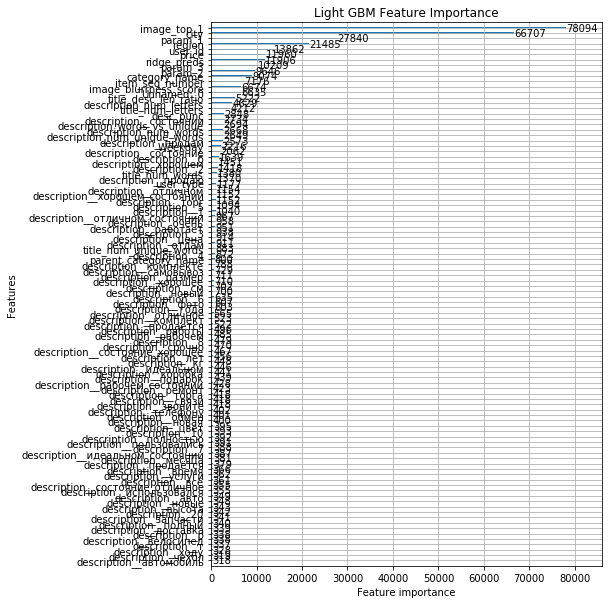

In [37]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=100, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')

print("Model Evaluation Stage")
lgpred = lgb_clf.predict(testing) 

#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub.csv",index=True,header=True)
#print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))